# Algorytmy macierzowe
## lab 2

In [1]:
import numpy as np
from time import time
from matplotlib import pyplot as plt

Własna klasa Number do zliczania ilości operacji

In [2]:
class Number(float):
    operation_counter = 0
    
    def __repr__(self) -> str:
        return f"{self:.8f}"
    
    def __radd__(self, other):
        Number.operation_counter += 1
        return Number(super().__radd__(other))

    def __add__(self, other):
        Number.operation_counter += 1
        return Number(super().__add__(other))
    
    def __rsub__(self, other):
        Number.operation_counter += 1
        return Number(super().__rsub__(other))

    def __sub__(self, other):
        Number.operation_counter += 1
        return Number(super().__sub__(other))
    
    def __mul__ (self, other):
        Number.operation_counter += 1
        return Number(super().__mul__(other))
    
    def __rmul__ (self, other):
        Number.operation_counter += 1
        return Number(super().__rmul__(other))
    
    def __truediv__(self, other):
        Number.operation_counter += 1
        return Number(super().__truediv__(other))
    
    def __rtruediv__(self, other):
        Number.operation_counter += 1
        return Number(super().__rtruediv__(other))
    
    def counter_reset():
        Number.operation_counter = 0

Generowanie macierzy

In [3]:
def random_matrix(matrix_size, min_val, max_val):
    """Return matrix with random Number floats from [min_val, max_val)"""
    matrix = (max_val - min_val) * np.random.random(matrix_size) + min_val
    return np.array([[Number(value) for value in row] for row in matrix], dtype=Number)

def transform_to_float(A):
    """np.linalg.inv doesnt work with dtype=Number"""
    return np.array(A, dtype=float)

In [4]:
exp = 2
matrix_size = (2**exp, 2**exp)

min_val = 0.00000001
max_val = 1

A = random_matrix(matrix_size, min_val, max_val)

### Rekurencyjne odwracanie macierzy

In [20]:
def inverse(A):
    if A.shape[0] != A.shape[1]:
        print("ERROR: Wrong matrix size!")
        return None
    
    if len(A) == 1:
        return np.array([[1/A[0,0]]])
    
    if len(A) == 2:
        return np.array(
            [[A[1,1], -A[0,1]],
             [-A[1, 0], A[0,0]]]
        ) / (A[0,0]*A[1,1] - A[0,1]*A[1,0])
        
    matrix_size = len(A)
    A11 = A[:matrix_size//2, :matrix_size//2]
    A12 = A[:matrix_size//2, matrix_size//2:]
    A21 = A[matrix_size//2:, :matrix_size//2]
    A22 = A[matrix_size//2:, matrix_size//2:]
    
    A11_inv = inverse(A11)
    S22 = A22 - A21 @ A11_inv @ A12
    S22_inv = inverse(S22)
    B11 = A11_inv @ (np.identity(len(A11)) + A12 @ S22_inv @ A21 @ A11_inv)
    B12 = -A11_inv @ A12 @ S22_inv
    B21 = -S22_inv @ A21 @ A11_inv
    B22 = S22_inv
    
    return np.vstack((np.hstack((B11, B12)), np.hstack((B21, B22))))

In [29]:
Number.counter_reset()
res = inverse(A)

print(f"Matrix size: {matrix_size}")
print("Number of operations:", Number.operation_counter)
print("Is correct?:", np.allclose(transform_to_float(res), np.linalg.inv(transform_to_float(A))))

Matrix size: (4, 4)
Number of operations: 134
Is correct?: True


### Rekurencyjna LU faktoryzacja

In [30]:
def LU_factorization(A):
    if A.shape[0] != A.shape[1]:
        print("ERROR: Wrong matrix size!")
        return None
    
    if len(A) == 1:
        L = np.array([[Number(1.0)]], dtype=Number)
        U = A.copy()
        return L, U
    
    matrix_size = len(A)
    A11 = A[:matrix_size//2, :matrix_size//2]
    A12 = A[:matrix_size//2, matrix_size//2:]
    A21 = A[matrix_size//2:, :matrix_size//2]
    A22 = A[matrix_size//2:, matrix_size//2:]
    
    L11, U11 = LU_factorization(A11)
    U11_inv = inverse(U11)
    L21 = A21 @ U11_inv
    L11_inv = inverse(L11)
    U12 = L11_inv @ A12
    S = A22 - A21 @ U11_inv @ L11_inv @ A12
    LS, US = LU_factorization(S)
    
    L = np.vstack((np.hstack((L11, np.zeros(A11.shape))), np.hstack((L21, LS))))
    U = np.vstack((np.hstack((U11, U12)), np.hstack((np.zeros(A11.shape), US))))
    return L, U

In [32]:
Number.counter_reset()
L, U = LU_factorization(A)

print(f"Matrix size: {matrix_size}")
print("Number of operations:", Number.operation_counter)
print("Is correct?:", np.allclose(transform_to_float(A), transform_to_float(L @ U)))


Matrix size: (4, 4)
Number of operations: 86
Is correct?: True


### Rekurencyjne obliczanie wyznacznika

In [28]:
def det(A):
    L, U = LU_factorization(A)
    result = 1
    for i in range(len(A)):
        result *= L[i, i] * U[i, i]
    return result

In [38]:
Number.counter_reset()
A_det = det(A)

print(f"Matrix size: {matrix_size}")
print("Number of operations:", Number.operation_counter)
print("Is correct?:", abs(A_det - np.linalg.det(transform_to_float(A))) < 1e-8)

Matrix size: (4, 4)
Number of operations: 94
Is correct?: True


### Testy

In [56]:
sizes = [2 ** e for e in range(1, 11)]

In [57]:
res_times = []
res_operations = []

for n in sizes:
    A = random_matrix((n, n), min_val, max_val)
    
    Number.counter_reset()
    t_start = time()
    inverse(A)
    inverse_time = time() - t_start
    inverse_op = Number.operation_counter
    
    Number.counter_reset()
    t_start = time()
    LU_factorization(A)
    lu_time = time() - t_start
    lu_op = Number.operation_counter
    
    Number.counter_reset()
    t_start = time()
    det(A)
    det_time = time() - t_start
    det_op = Number.operation_counter
    
    res_times.append((inverse_time, lu_time, det_time))
    res_operations.append((inverse_op, lu_op, det_op))


In [58]:
print([x[0] for x in res_times])
print([x[1] for x in res_times])
print([x[2] for x in res_times])

[0.0, 0.0, 0.0009996891021728516, 0.005522727966308594, 0.05115056037902832, 0.3662900924682617, 3.05409574508667, 25.206032276153564, 204.99777054786682, 1621.803947210312]
[0.0, 0.0, 0.0009970664978027344, 0.006990194320678711, 0.03822183609008789, 0.2992830276489258, 2.4233384132385254, 19.982911348342896, 163.83248949050903, 1283.579090833664]
[0.0, 0.001001596450805664, 0.001001119613647461, 0.007003307342529297, 0.038867950439453125, 0.29413390159606934, 2.373581647872925, 20.164924144744873, 165.9969687461853, 1279.7876586914062]


In [59]:
print([x[0] for x in res_operations])
print([x[1] for x in res_operations])
print([x[2] for x in res_operations])

[3, 134, 1420, 12568, 105008, 857184, 6924480, 55660928, 446341888, 3574941184]
[8, 86, 944, 9200, 81032, 677096, 5525512, 44616456, 358517384, 2874317960]
[12, 94, 960, 9232, 81096, 677224, 5525768, 44616968, 358518408, 2874320008]


Wykresy

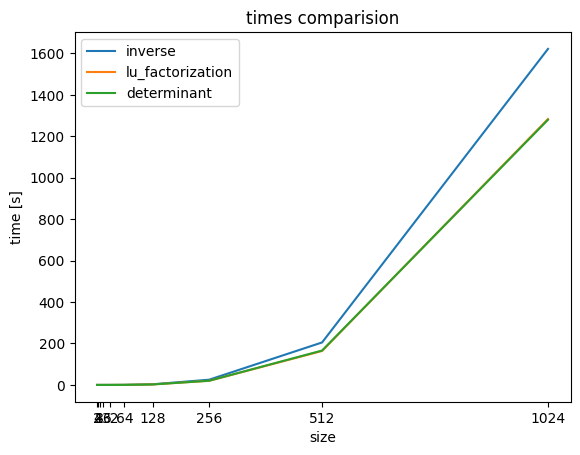

In [60]:
plt.plot(sizes, res_times)
plt.title("times comparision")
plt.xlabel("size")
plt.ylabel("time [s]")
plt.xticks(sizes)
plt.legend(("inverse", "lu_factorization", "determinant"))
plt.show()

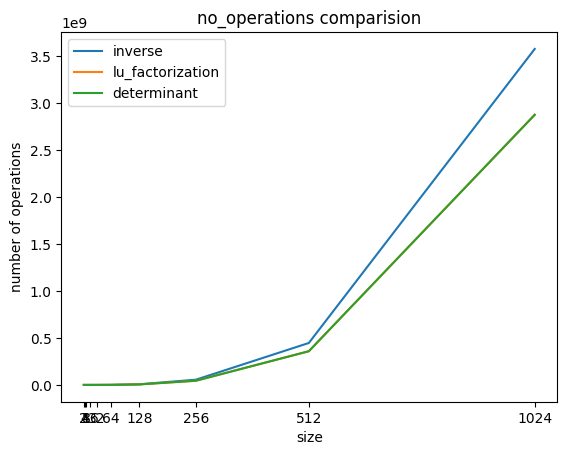

In [61]:
plt.plot(sizes, res_operations)
plt.title("no_operations comparision")
plt.xlabel("size")
plt.ylabel("number of operations")
plt.xticks(sizes)
plt.legend(("inverse", "lu_factorization", "determinant"))
plt.show()